# Methodology-2 – Detect and Fix Multicollinearity

- Get a data set
- Get the user to provide the responsive variable
- Clean the data to fix null and missing values 
- Compute a correlation matrix
- Provide  a visualization of highly correlated variables
- When two variables are highly correlated drop the one that contributes less to the model89


The above will be achieved by following functions :

    - Visualisations
    - missing_values
    - cal_corr
    - train_split
    - remove_correlated_features

the objective is to produce a dataset without Multicollinearity

In [1]:
#import the following packages
import json    # to load config file
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from IPython.display import display

In [2]:
#this class helps to bold header text in the report
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [3]:
# purpose -: to display correlation heat map and correlation matrix
# input   -: dataset
# output  -: visualization

def visualizations(dataset):
    #correlation
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('\nCorrelation Analysis', fontsize = 20) 
    sns.heatmap(dataset.corr(), annot = True, cmap="YlGnBu")   #heat map plotter
    plt.show()
    print('\n'*2)
    print('-'*120)
    print('\n')
    print(color.BOLD + 'Correlation Matrix'+ color.END)
    display(dataset.corr()) # display correlation n*n matrix

In [4]:
# purpose -: resolves missing values from the dataset and isolates categorical featurs
# input   -: dataset and strategy to resolve missing values
# output  -: dataset without missing values and categorical features


def missing_values(dataset,missing_strategy='mean'): # default strategy to resolve missing values is using column mean
    numerics = ['int16', 'int32','int64', 'float16', 'float32', 'float64'] 
    numerical_features = list(dataset.select_dtypes(include=numerics).columns) # select all columns that are numeric type
    dataset=dataset[numerical_features] # new dataset which excludes categorical data
    result=dataset.isnull().sum()
    missing=[]   # list to save variables with missing values
    for i in range(len(result)):
        if(result[i]>0):
            missing.append(i)  #save missing values
    if(len(missing)==0):
        print('no missing values')  # message if there are no variables with missing variables
        
    else:
        for i in missing:
            print(result.index[i] + " had : {} missing values : Resolved".format(result[i]))
            
            selection = missing_strategy
            if(selection=='zero'):
                dataset=dataset.fillna(0)   # fill in zeros to missing values 
            else:
                dataset=dataset.apply(lambda x: x.fillna(x.mean()),axis=0) # fill in missing value using mean in column
            
    return dataset
    

In [5]:
# purpose -: calculates correlation and records all highly correlated pairs 
# input   -: dataset with only numerical features and correlation threshold
# output  -: correlation matrix


def cal_corr(dataset,target,threshold=0.8): # default correlation matrix is 0.8

    dataset=dataset.drop(columns=[target]) 
    corr_matrix = dataset.corr()     # Build a Dataframe of highly correlated variables
    # Take absolute values of highly correlated coefficients
    corr_matrix = corr_matrix.abs().unstack()   #unstack the n*n matrix to 3*all variable possible combinations of 2s
    corr_matrix = corr_matrix.sort_values(ascending=False) # sort the table in descending order
    # Take only features with correlation above threshold
    corr_matrix = corr_matrix[corr_matrix >= threshold] 
    corr_matrix = corr_matrix[corr_matrix < 1]
    corr_matrix = pd.DataFrame(corr_matrix).reset_index()
    corr_matrix.columns = ['feature1', 'feature2', 'Correlation'] #table with correlated features and correlation coefficient
    
    return corr_matrix

In [6]:
# purpose -: data spliting and dropping a column.
# input   -: dataset, and column to be in the dataset
# output  -: split dataset

def train_split(dataset,to_be_dropped,target):

    dataset=dataset.drop(columns=[to_be_dropped])
    x_train,x_test,y_train,y_test=train_test_split(dataset.drop(columns=[target]),dataset[target],train_size=0.7,random_state=100)

    return x_train,x_test,y_train,y_test
    

In [7]:
# purpose -: remove correlated features 
# input   -: dataset, target and treshold
# output  -: dataset without features with high correlation


def remove_correlated_features(dataset,target,threshold):
    iterations=1 # initialize loop
    corr_matrix=cal_corr(dataset,target,threshold) #call cal_corr function to get a table of highly correlated features
    print(color.BOLD +'\nTable of highly correlated features'+ color.END)
    print('\n')
    display(corr_matrix)
    
    
    print('_'*120)
    print('\n')
    print(color.BOLD +'Removing highly correlated features'+ color.END)
    print('\n')
    
    
    
    #the function has a loop the loop performs the following 
    #-from the table of highly correlated features, the table takes the top 2 features in each loop
    #-the first feature is removed from the dataset, the dataset is slipt by the train_slipt function
    #-the train set is fit on the model, and an R2 is saved
    #-the second feature is also done the same as the first
    #-the feature which cotributes a high R2 score between the e features is eliminated
    #-any row with the eliminated feature is removed the table of features with high correlation
    #-the process is repeated until the table is empty
    min_col = []
    max_col = []
    while(iterations==1):
        correlated_col=[]   #save the curent correlated features
        res=[]                 #stores R2
        rem_col = []

        try:
            for i in range(2):  #collect the 2 correlated features
                 correlated_col.append(corr_matrix.iloc[0][i])    # take the top correlated features from the table


            for i in range(2): #iterate the 2 correlated features
                col=correlated_col[i]  
                try :    
                    x_train,x_test,y_train,y_test=train_split(dataset,col,target) # remove the features from the deataset one by one
                    lm = LinearRegression() 
                    lm.fit(x_train,y_train)  #fit the model 

                    y_train_pred = lm.predict(x_train)
                    y_test_pred = lm.predict(x_test)

                    

                    res.append(r2_score(y_test,y_test_pred)) # evaluates R2 and saves the R2 score with the removed feature



                except TypeError:
                    print('Cannot drop target')       
           
            
            min_col.append([correlated_col[res.index(min(res))],res[res.index(min(res))]])
            max_col.append([correlated_col[res.index(max(res))],res[res.index(max(res))]])

            
            dataset=dataset.drop(columns=[correlated_col[res.index(min(res))]]) #eliminates the feature which contributes less to the model from the dataset using R2 score
            corr_matrix.drop(corr_matrix.index[(corr_matrix["feature1"] == correlated_col[res.index(min(res))])],axis=0,inplace=True) # eliminate feature from table of highly correlated features
            corr_matrix.drop(corr_matrix.index[(corr_matrix["feature2"] == correlated_col[res.index(min(res))])],axis=0,inplace=True)



        except IndexError:
            
            iterations=0
    
            
    print('Selection Criterion : R Squared - higher is desirable \n-Features in the Keep_Features column will be kept in the dataset \n-Features in the Remove_Features will be removed from the dataset')
    
    feat_keep = pd.DataFrame(min_col, columns=['Removed_Features', 'R2 Score_'])
    delete_keep = pd.DataFrame(max_col,columns=['Keep_Features', 'R2 Score'])
    
    df= feat_keep.merge(delete_keep,left_index=True,right_index=True)
    
    display(df)
            
    return dataset

In [8]:
# purpose -: read the config file, call other other function to process the data
# input   -: none
# output  -: dataset witout Multicollinearity

def load_and_process():
    
    with open('config.json') as f:
        data = json.load(f)
    
    path = data['path']
    #loading dataset
    try:
        dataset = pd.read_csv(path)

    except FileNotFoundError:
         print('File not found please enter again \n') # error message if path is not found

    #loading target
    cols=dataset.columns          #collect all column names
    
    
    target = data['target_variable']
    
    if(target in(cols)):      #check if target column is a column in the dataset

        target=data['target_variable']

    else:
         print('\n Target column found try again') # error message if target is not found

    #loading threshold
    try : 
        threshold = float(data['correlation_threshold']) # check if value is numerical
    except ValueError:
         print('Enter again threshold not numerical')
    
    missing=data['missing_value_strategy']
    
    if(missing=='zero' or missing=='mean'):
        missing=data['missing_value_strategy']
    else:
        print('-----------------------------------------------')
        print('Missing value strategy is not valid \nSelect between zero or mean \ndefault mean will be used')
        print('-----------------------------------------------')
    
    print('The following parameters have been loaded from the config file\n')  #shows the user the parameters in the config file
    print('Dataset file path  :',path)
    print('Target variable :',target)
    print('Correlation Threshold :',threshold)
    print('Missing value Strategy :',missing)
    print('-'*50)
    
    dataset=missing_values(dataset,missing)  #processes the missing values
    dataset_target=dataset[target]
    print('_'*120)
    visualizations(dataset) # displays visualizations (heatmape for correlation of features and the correlation matrix)
    print('\n')
    print('_'*120)
    
    
    dataset=remove_correlated_features(dataset,target,threshold)
    
    print('\n')
    
    dataset.to_csv('nc_'+path)
    print('Dataset without Multicollinearity will be saved in : nc_{}'.format(path))
    print('_'*120)
    
    
    
    return dataset,target

The following parameters have been loaded from the config file

Dataset file path  : Credit-Scoring-Clean.csv
Target variable : CreditStatus
Correlation Threshold : 0.8
Missing value Strategy : mean
--------------------------------------------------
no missing values
________________________________________________________________________________________________________________________


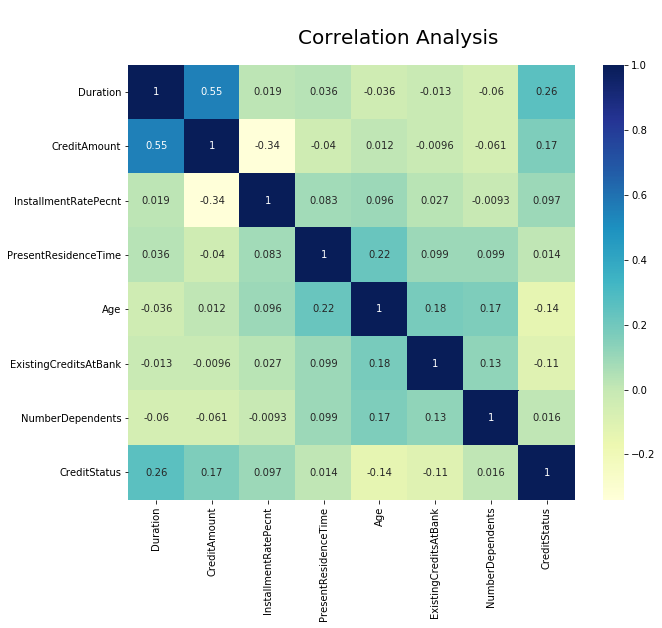




------------------------------------------------------------------------------------------------------------------------


Correlation Matrix


,Duration,CreditAmount,InstallmentRatePecnt,PresentResidenceTime,Age,ExistingCreditsAtBank,NumberDependents,CreditStatus
Duration,1.000000,0.554653,0.019456,0.036132,-0.036233,-0.013222,-0.059799,0.257448
CreditAmount,0.554653,1.000000,-0.339137,-0.040389,0.011901,-0.009640,-0.061291,0.165472
InstallmentRatePecnt,0.019456,-0.339137,1.000000,0.083295,0.095750,0.027304,-0.009261,0.097442
PresentResidenceTime,0.036132,-0.040389,0.083295,1.000000,0.222569,0.099359,0.099288,0.014401
Age,-0.036233,0.011901,0.095750,0.222569,1.000000,0.181280,0.166937,-0.140142
ExistingCreditsAtBank,-0.013222,-0.009640,0.027304,0.099359,0.181280,1.000000,0.125038,-0.108153
NumberDependents,-0.059799,-0.061291,-0.009261,0.099288,0.166937,0.125038,1.000000,0.015724
CreditStatus,0.257448,0.165472,0.097442,0.014401,-0.140142,-0.108153,0.015724,1.000000




________________________________________________________________________________________________________________________

Table of highly correlated features




,feature1,feature2,Correlation


________________________________________________________________________________________________________________________


Removing highly correlated features


Selection Criterion : R Squared - higher is desirable 
-Features in the Keep_Features column will be kept in the dataset 
-Features in the Remove_Features will be removed from the dataset


,Removed_Features,R2 Score_,Keep_Features,R2 Score




Dataset without Multicollinearity will be saved in : nc_Credit-Scoring-Clean.csv
________________________________________________________________________________________________________________________


In [9]:
dataset,target=load_and_process()

## Methodology-4   Variable Selection Selection using Extra TreesClassifier

- Get a data set
- Get the user to provide the responsive variable
- Clean the data to fix null and missing values 
- Run Cross Validation
- Provide the statistics for variable significance
- Provide a visualization of the most significant variables


The following will be achieved by the following functions :

 - cross_validation  - processing crossvalidation
 - cross_val_results - showing crossvalidation results
 - feature_selection - selecting features high score yeilding results

In [10]:
#import the following packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel 
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [11]:
# purpose -: to crossvalidate the model over the several different combination of features
# input   -: x_train and y_train
# output  -: dataset witout Multicollinearity


def cross_validation(X_train,y_train):
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    number_of_feat=len(X_train.columns)+1

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_features_to_select': list(range(1,number_of_feat))}]


    # step-3: perform grid search
    # 3.1 specify model
    model = ExtraTreesClassifier()
    model.fit(X_train, y_train)
    rfe = RFE(model)             

    # 3.2 call GridSearchCV()
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)      

    # fit the model
    model_cv.fit(X_train, y_train)    
    
    return  model_cv

In [12]:
# purpose -: to report results of crossvalidation
# input   -: dataset,target
# output  -: crossvalidation result table 


def cross_val_results(dataset,target):
    X_train = dataset.drop(columns=[target])
    y_train = dataset[target]
    model_cv=cross_validation(X_train,y_train)
    #results table
    cv_results = pd.DataFrame(model_cv.cv_results_)
    #collect necessary information 
    cv_results_keep=cv_results[['param_n_features_to_select','mean_test_score','mean_train_score','rank_test_score']]
    
        
    print('_'*120)
    print('\n')
    print(color.BOLD +'Crossvalidation Results'+ color.END)
    print('\n')
    
    #Display results
    
    display(cv_results_keep)
    
    # plotting cv results
    plt.figure(figsize=(16,6))
    
    
    print('\n'*2)
    print('-'*120)
    print('\n')
    print(color.BOLD +'Optimal Number of Features'+ color.END)
    print('\n')
    

    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.show()
    
    return  cv_results_keep

In [13]:
# purpose -: select important features
# input   -: dataset,target
# output  -: dataset with selected features


def feature_selection(dataset,target):
    cv_results_keep=cross_val_results(dataset,target)
    #use the table from crossvalidation to select features
    #to avoid overfitting features with high mean test score compared to features from a model with high mean train score are considered
    number_of_feat = cv_results_keep.param_n_features_to_select.iloc[cv_results_keep['param_n_features_to_select'].index[cv_results_keep['mean_test_score'].idxmax()]]
    
    # final model
    n_features_optimal = number_of_feat

    clf = ExtraTreesClassifier(n_estimators=50) 
    clf=clf.fit(dataset.drop(columns=[target]), dataset[target])
    # Computing the importance of each feature 
    feature_importance = clf.feature_importances_ 

    # Normalizing the individual importances 
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                            clf.estimators_], 
                                            axis = 0) 
    #table of importance features and their scores
    columns=dataset.drop(columns=[target]).columns
    #table of importance features and their scores
    columns=dataset.drop(columns=[target]).columns
    feature_import = pd.DataFrame(columns, columns=['Features'])
    feature_import['Importance Score']= feature_importance
    
    feature_import=feature_import.sort_values(by='Importance Score',ascending=False)
    columns=feature_import['Features'].values


    print('\n'*2)
    print('-'*120)
    print('\n')
    print(color.BOLD +'Important Features'+ color.END)
    print('\n')

    # Figure Size 

    fig, ax = plt.subplots(figsize =(10, 3)) 
    # Horizontal Bar Plot 
    ax.barh( columns, feature_import['Importance Score'].values)
    # Remove axes splines 
    plt.show()
    
    print('\n'*2)

    
    display(feature_import)
    
    dataset=dataset[columns[:n_features_optimal]]
    
    print('_'*120)
    
    return dataset
    

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


________________________________________________________________________________________________________________________


Crossvalidation Results




[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   18.6s finished


,param_n_features_to_select,mean_test_score,mean_train_score,rank_test_score
0,1,-0.976621,0.961686,7
1,2,-0.327789,1.000000,6
2,3,-0.315422,1.000000,5
3,4,-0.118810,1.000000,4
4,5,-0.067530,1.000000,3
5,6,0.051821,1.000000,2
6,7,0.090012,1.000000,1





------------------------------------------------------------------------------------------------------------------------


Optimal Number of Features




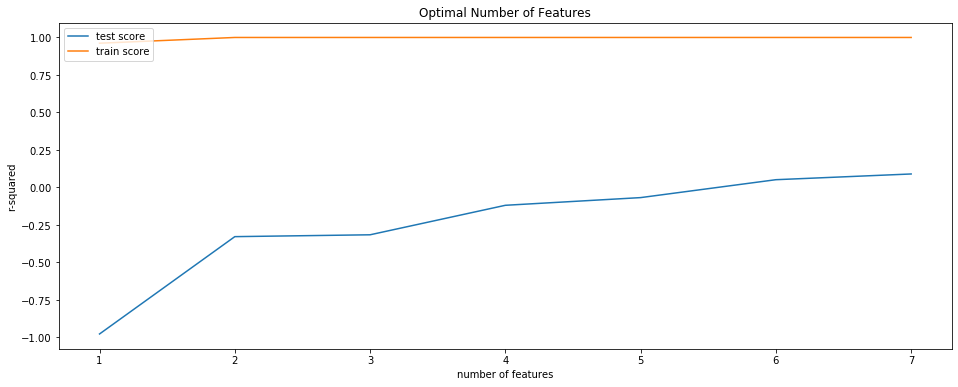




------------------------------------------------------------------------------------------------------------------------


Important Features




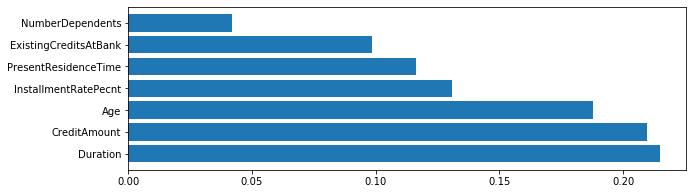

,Features,Importance Score
0,Duration,0.214822
1,CreditAmount,0.209762
4,Age,0.187698
2,InstallmentRatePecnt,0.131002
3,PresentResidenceTime,0.116469
5,ExistingCreditsAtBank,0.098387
6,NumberDependents,0.041860


________________________________________________________________________________________________________________________


In [14]:
new_dataset=feature_selection(dataset,target)